In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reference - http://savvastjortjoglou.com/nfl-survival-analysis-kaplan-meier.html

Event of interest is customer churn. The duration of time leading up to the event of interest is called survival time.In this case the survival time is the duration in months that the customer stayed with the company (tenure). 
Also, here there is no issue of censorship as both survival time and event of interest is known for all records

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv') 

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# decoding Churn variable
df['Churn'] = df['Churn'].replace({'Yes':1,'No':0})

this is not time series data, so we will assume all customers start at t = 0 
and continue until t = tenure

## Estimating the survival function

In [6]:
from lifelines import KaplanMeierFitter

In [7]:
# setting some plotting aesthetics, similar to ggplot
sns.set(palette = "colorblind", font_scale = 1.35, 
        rc = {"figure.figsize": (12,9), "axes.facecolor": ".92"})

In [8]:
kmf = KaplanMeierFitter() 

In [9]:
# The 1st arg accepts an array or pd.Series of individual survival times
# The 2nd arg accepts an array or pd.Series that indicates if the event 
# interest (or churn) occured.
kmf.fit(durations = df.tenure, event_observed = df.Churn)

<lifelines.KaplanMeierFitter: fitted with 7043 observations, 5174 censored>

In [10]:
#After fitting data the event table can be accessed that contains a bunch of information regarding customers at each time period.

In [11]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,11,0,11,7043,7043
1,613,380,233,0,7032
2,238,123,115,0,6419
3,200,94,106,0,6181
4,176,83,93,0,5981
5,133,64,69,0,5805
6,110,40,70,0,5672
7,131,51,80,0,5562
8,123,42,81,0,5431


The removed column contains the number of observations removed during that time period, whether due to churn
(the value in the observed column) or censorship. So the removed column is just the sum of the observed and censorship columns. 
The entrance column tells us whether any new subjects entered the population at that time period. Since assuming all the customers we are studying start at time=0, the entrance value is 7043 at that time and 0 for all other times.

The at_risk column contains the number of subjects that are still alive during a given time. The value for at_risk at time=0, 
is just equal to the entrance value. For the remaining time periods, the at_risk value is equal to the difference between the 
time previous period's at_risk value and removed value, plus the current period's entrance value. For example for time=1, 
the number of subject's at risk is 7032 which is equal to 7043 (the previous at_risk value) -11 (the previous removed value) + 0 (the current period's entrance value).

Thus by making use of this survival table, we can calculate the survival probability at different times.

The value of the survival function for time t, is the product of the survival probabilities for all individual time periods leading up to time t.

Survival probability for an individual time period is shown as below

St = (Number of subjects at risk at the start− Number of subjects that churned)/ Number of subjects at risk at the start

In [12]:
# For eg: to calculate the probability that customer lasts longer than 3 months
event_at_0 = kmf.event_table.iloc[0, :]
# now calculating the survival probability for t = 0
surv_for_0 =  (event_at_0.at_risk - event_at_0.observed) / event_at_0.at_risk
print(surv_for_0)

# Calculating the survival probability for t = 1
event_at_1 = kmf.event_table.iloc[1, :]
surv_for_1 =  (event_at_1.at_risk - event_at_1.observed) / event_at_1.at_risk
print(surv_for_1) 
# surv_for_1 represents the conditional probability that if a customer does not immediately churn once joining the company, 
# then he has a surv_for_1% chance of remaining in company for 1 year.

# Calculating the survival probability for t = 2
event_at_2 = kmf.event_table.iloc[2, :]
surv_for_2 =  (event_at_2.at_risk - event_at_2.observed) / event_at_2.at_risk
print(surv_for_2)

1.0
0.945961319681
0.980838136781


There is 98 % probability that customer remains in company for 2 nd month given that he did not churn in the first month

In [13]:
# The probability that customer has a tenure longer than 2 months
surv_after_2 = surv_for_0 * surv_for_1 * surv_for_2
surv_after_2

0.92783493826366237

In [14]:
# But we can get the survival probability after a given time by simply using the predict method.
kmf.predict(12) # to get survival probability after 12 months

0.84319955381583023

In [15]:
# To get the full list of estimated probabilities from KaplanMeierFitter, accessing the survival_function_ attribute.
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.945961
2.0,0.927835
3.0,0.913725
4.0,0.901045
5.0,0.891111
6.0,0.884826
7.0,0.876713
8.0,0.869933


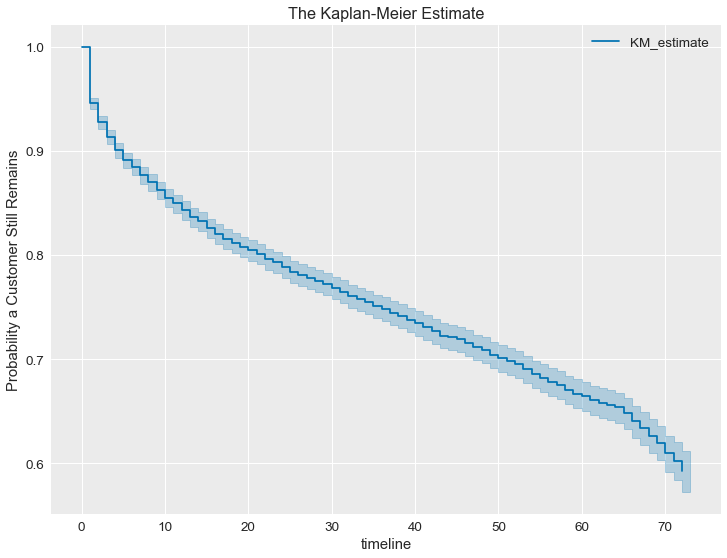

In [16]:
# plot the KM estimate
kmf.plot()
# Add title and y-axis label
plt.title("The Kaplan-Meier Estimate")
plt.ylabel("Probability a Customer Still Remains")

plt.show()


Kaplan-Meier estimate is a step function. Each horizontal line represents the probability that a customer is 
still with company after a given time t. For example, when t=20, the 
probability that a player is still active after that point is about 82%.